## EDA

In [65]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [66]:
#create Spark session
spark = SparkSession.builder.appName('YelpML').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
#spark.sparkContext.getConf().getAll()

In [106]:
# Import Data
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-datasample2"
business = spark.read.json(dataDir + "/sample_business")
checkin = spark.read.json(dataDir + "/sample_checkin")
review = spark.read.json(dataDir + "/sample_review")
tip = spark.read.json(dataDir + "/sample_tip")
user = spark.read.json(dataDir + "/sample_user")

In [38]:
business.show(5)

+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|            address|          attributes|         business_id|          categories|               city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|      2141 Caton St|{null, null, null...|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|        New Orleans|{0:0-0:0, 0:0-0:0...|      1|   29.9991154|   -90.0607732|     Anytime Fitness|      70122|           6|  3.0|   LA|
|5413 Neshaminy Blvd|{null, null, u'no...|p184f-Zvf4ToPwLba...|Chinese, Restaura...|           Bensalem|{11:30-23:0,

In [5]:
from pyspark.sql.functions import isnan, when, count
business.select([count(when(business[c].isNull(), c)).alias(c) for c in business.columns]).show()

+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|      0|       170|          0|         2|   0|  250|      0|       0|        0|   0|          0|           0|    0|    0|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+



In [6]:
# 1. How many unique business?
business.select('business_id').distinct().count()

1617

In [7]:
# 2. What are the top 10 categories?
business.select('categories').distinct().show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------+
|African, American (Traditional), Restaurants                                                                           |
|Cosmetics & Beauty Supply, Nail Salons, Shopping, Beauty & Spas                                                        |
|Parks, Active Life                                                                                                     |
|Obstetricians & Gynecologists, Health & Medical, Doctors                                                               |
|Shopping, Food, Drugstores, Pharmacy, Health & Medical, Convenience Stores                                             |
|Food, Ice Cream & Froze

In [37]:
from pyspark.sql.functions import explode, split
business1 = business.withColumn('categories_split', explode(split('categories', ', ')))

In [27]:
df1 = business1.groupby('categories_split').count().orderBy('count', ascending = [0])

In [10]:
df1.show(10, truncate = False)

+----------------+-----+
|categories_split|count|
+----------------+-----+
|Restaurants     |589  |
|Food            |303  |
|Shopping        |264  |
|Beauty & Spas   |154  |
|Home Services   |145  |
|Health & Medical|132  |
|Automotive      |129  |
|Nightlife       |124  |
|Bars            |113  |
|Local Services  |111  |
+----------------+-----+
only showing top 10 rows



In [11]:
pdf1 = df1.toPandas()
pdf1.head()

,categories_split,count
0,Restaurants,589
1,Food,303
2,Shopping,264
3,Beauty & Spas,154
4,Home Services,145


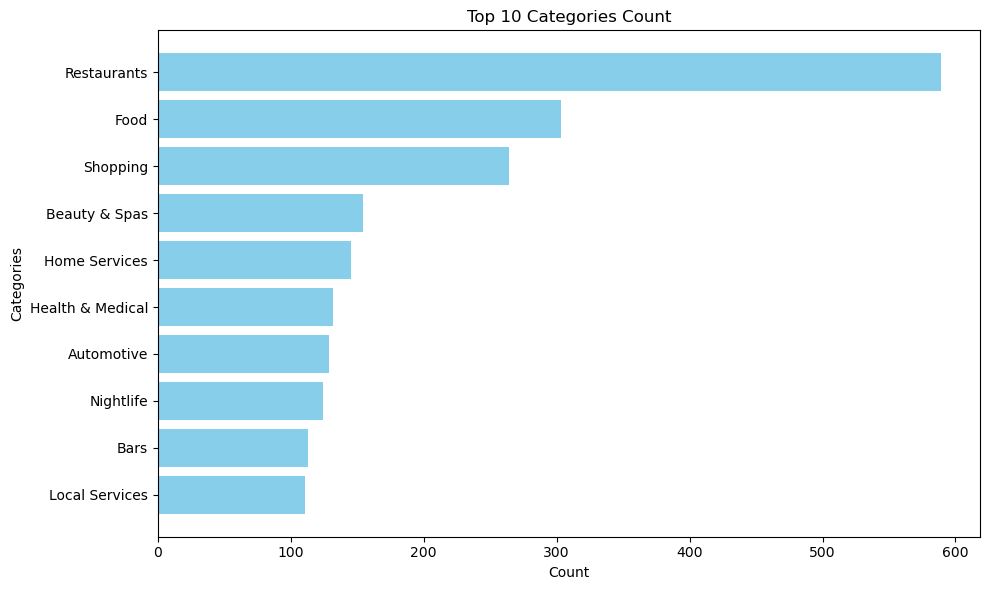

In [12]:
top_10_categories = pdf1.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_categories['categories_split'], top_10_categories['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.title('Top 10 Categories Count')
plt.gca().invert_yaxis()  
plt.tight_layout()

# Display the plot
plt.show()

In [13]:
# 3. Business Location

In [14]:
df2 = business.groupby('state').count().orderBy('count', ascending =[0])

In [15]:
df2.show()

+-----+-----+
|state|count|
+-----+-----+
|   PA| 1715|
|   FL| 1310|
|   MO|  591|
|   TN|  563|
|   IN|  495|
|   AZ|  468|
|   LA|  454|
|   NJ|  425|
|   NV|  330|
|   CA|  243|
|   ID|  217|
|   AB|  188|
|   IL|  109|
|   DE|   77|
|   WA|    2|
+-----+-----+



In [16]:
pdf2 = df2.toPandas()
pdf2.head()

,state,count
0,PA,1715
1,FL,1310
2,MO,591
3,TN,563
4,IN,495


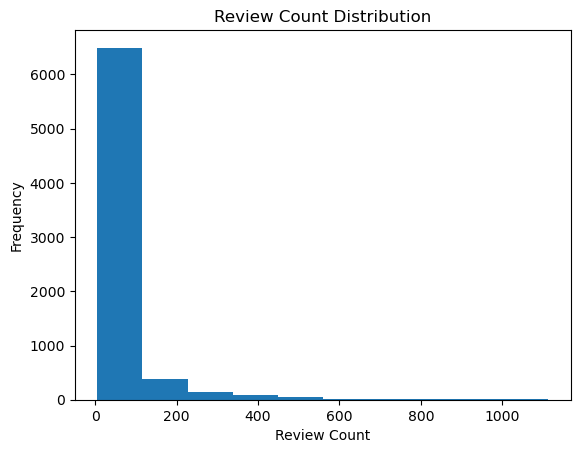

In [28]:
# Review Count Distribution
review_count_dist = business.select("review_count").rdd.flatMap(lambda x: x).histogram(10)
counts = review_count_dist[1]
bins = review_count_dist[0]

plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.title('Review Count Distribution')
plt.show()

In [57]:
max_review_count = business.selectExpr("max(review_count) as max_review_count").collect()[0]["max_review_count"]
min_review_count = business.selectExpr("min(review_count) as min_review_count").collect()[0]["min_review_count"]
avg_review_count = business.selectExpr("avg(review_count) as avg_review_count").collect()[0]["avg_review_count"]
median_review_count = business.approxQuantile("review_count", [0.5], 0.01)[0]

print(f"Max Review Count: {max_review_count}")
print(f"Min Review Count: {min_review_count}")
print(f"Avg Review Count: {avg_review_count}")
print(f"Median Review Count: {median_review_count}")

Max Review Count: 1113
Min Review Count: 5
Avg Review Count: 39.33828076685219
Median Review Count: 14.0


In [53]:
# Top 10 Review Count Business
from pyspark.sql.functions import col, expr, desc
df3 = business.orderBy(desc("review_count")).limit(10).select("name", "review_count", 'stars')

In [54]:
df3.show(truncate = False)

+---------------------------+------------+-----+
|name                       |review_count|stars|
+---------------------------+------------+-----+
|Sugarfire Smoke House      |1113        |4.0  |
|El Rey                     |968         |3.5  |
|Saint Louis Zoo            |866         |4.5  |
|Wright's Gourmet House     |701         |4.5  |
|Yah Mon                    |697         |4.5  |
|The Pop Shop - Collingswood|603         |3.5  |
|Dock Street Brewery        |549         |4.0  |
|Cafe Sbisa                 |531         |4.5  |
|Triumph Brewing Company    |490         |3.5  |
|The Belgian Café           |474         |3.5  |
+---------------------------+------------+-----+



In [45]:
pdf3 = df3.toPandas()
pdf3.head()

,name,review_count
0,Sugarfire Smoke House,1113
1,El Rey,968
2,Saint Louis Zoo,866
3,Wright's Gourmet House,701
4,Yah Mon,697


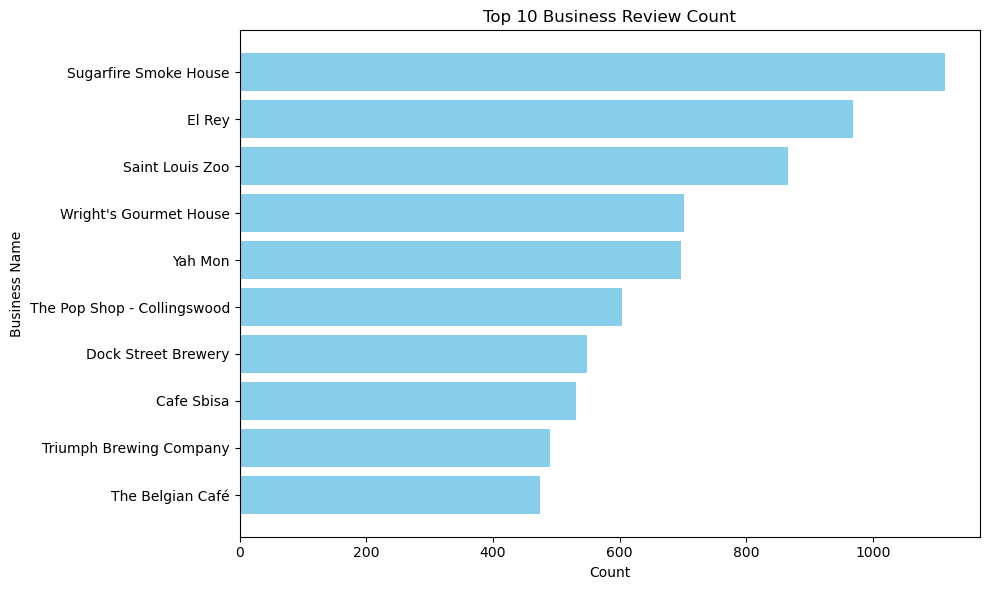

In [46]:
top_10_categories = pdf3.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_categories['name'], top_10_categories['review_count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Business Name')
plt.title('Top 10 Business Review Count')
plt.gca().invert_yaxis()  
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Ratings Distribution

In [48]:
max_rating = business.selectExpr("max(stars) as max_rating").collect()[0]["max_rating"]
min_rating = business.selectExpr("min(stars) as min_rating").collect()[0]["min_rating"]
avg_rating = business.selectExpr("avg(stars) as avg_rating").collect()[0]["avg_rating"]

print(f"Max Rating: {max_rating}")
print(f"Min Rating: {min_rating}")
print(f"Avg Rating: {avg_rating}")

Max Rating: 5.0
Min Rating: 1.0
Avg Rating: 3.6020408163265305


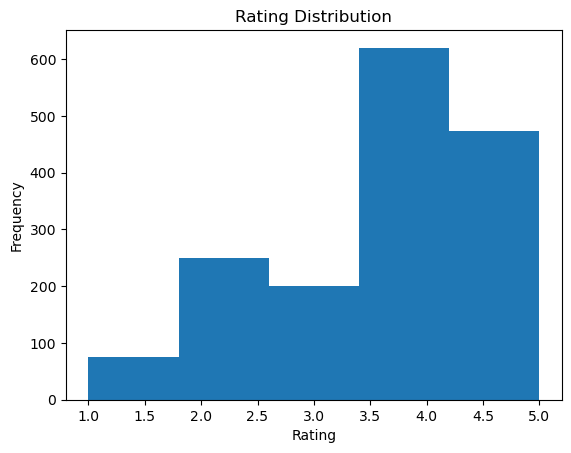

In [49]:
rating_dist = business.select("stars").rdd.flatMap(lambda x: x).histogram(5)  
counts = rating_dist[1]
bins = rating_dist[0]

plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]), align='edge')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

In [55]:
top_ten_ratings = business.orderBy(desc("stars")).limit(10).select("name", "stars", 'review_count')
top_ten_ratings.show(truncate=False)

+---------------------------------+-----+------------+
|name                             |stars|review_count|
+---------------------------------+-----+------------+
|Nyejah Bolds Photography         |5.0  |8           |
|Michael C Gribbin, DMD           |5.0  |7           |
|Hair Force                       |5.0  |13          |
|Hot Diggity Dog                  |5.0  |5           |
|Able Garage Door Service         |5.0  |17          |
|Post Pack & Ship                 |5.0  |9           |
|Free Tours By Foot               |5.0  |184         |
|Karries Kostumes & Dance Supplies|5.0  |12          |
|Meyers Automotive                |5.0  |7           |
|Melissa Ems Insurance Agency     |5.0  |5           |
+---------------------------------+-----+------------+



Comparing the top restaurant lists given by highest rating versus highest review counts resulted in the observation that the two criteria don’t appear to show strong correlation to each other.

In [58]:
# So check the stars rank when review_count above average
top_ten_ratings = business.where(col('review_count') >= avg_review_count).orderBy(desc("stars")).limit(10).select("name", "stars", 'review_count')
top_ten_ratings.show(truncate=False)

+---------------------------------------------------+-----+------------+
|name                                               |stars|review_count|
+---------------------------------------------------+-----+------------+
|Free Tours By Foot                                 |5.0  |184         |
|Tim's Bakery                                       |5.0  |115         |
|Taste Santa Barbara Food Tours                     |5.0  |124         |
|Nok's Expert Thai Massage Center                   |5.0  |53          |
|Pure-trition                                       |5.0  |56          |
|Les Fleurs Salon                                   |5.0  |82          |
|The Artist Haus                                    |5.0  |78          |
|The Junkluggers of Philadelphia & Montgomery County|5.0  |40          |
|Pasta Fresca                                       |5.0  |159         |
|Newfields: A Place for Nature and the Arts         |4.5  |373         |
+--------------------------------------------------

In [59]:
high_rating_city = business.filter(col("stars") >= 4.5).groupBy("city").count().orderBy(desc("count")).first()
low_rating_city = business.filter(col("stars") <= 2.5).groupBy("city").count().orderBy(desc("count")).first()

print(f"City with most high-rated businesses: {high_rating_city['city']}, Count: {high_rating_city['count']}")
print(f"City with most low-rated businesses: {low_rating_city['city']}, Count: {low_rating_city['count']}")

City with most high-rated businesses: Philadelphia, Count: 49
City with most low-rated businesses: Philadelphia, Count: 36


In [61]:
checkin.show()
checkin.select([count(when(checkin[c].isNull(), c)).alias(c) for c in checkin.columns]).show()

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|SHZ3NhQj1FonMnKgd...|2010-03-07 03:15:...|
|SIc1YcqUBMdXO3Lxg...|2017-08-14 18:44:...|
|SJ3iTeHq3Om0SoruO...|2010-11-25 17:17:...|
|SLWMy4MsvvAAtiyYr...|2011-07-20 21:38:...|
|SN0cn8cxbTWiAhtP-...|2012-06-15 13:20:...|
|SOKZiTA5hhGGsAuAI...|2014-09-28 05:57:...|
|SekWxm92phAL_P_Ky...|2010-03-08 01:46:...|
|ShJiM9L-skL5Hd7RM...| 2012-06-24 21:11:48|
|SjEOtdNuQfBWZL0pZ...|2020-06-12 04:08:...|
|SoPn5xN-6AElJwsja...| 2017-12-08 18:17:56|
|StN1Kre3qoBwvbqv5...| 2013-08-08 16:51:13|
|Sw53KWMB8cYjF7EZX...|2015-09-30 00:41:...|
|SwJOeRUW0mFYDXTgJ...|2010-07-10 15:26:...|
|Swox1WnwaKpd20hog...| 2017-06-30 12:12:58|
|Sz5Gv-wehJpOQNH1u...|2015-02-13 17:32:...|
|T-BcPfWiAz5dRKWkQ...|2019-02-03 09:27:...|
|T0TOtx8E71DqO5Al5...|2011-12-29 21:13:...|
|T4VkmVfJScbLe21xL...|2010-07-12 16:16:...|
|T9JtKc0o9ApuVXg2z...|2012-12-29 19:16:...|
|TAX9sFriCKBeigt-t...| 2012-12-3

In [69]:
review.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|arKiXax3ScSM_z3O-...|   0|2010-10-17 01:50:46|    0|zCNdcNrkIKefTPbak...|  5.0|Great Italian foo...|     0|bz2FrqfKrVmS7WwC-...|
|aeFXIzYpWjSdtq5w8...|   3|2013-06-29 13:42:57|    0|aweHR8S6QAEuV4hoH...|  3.0|I have heard many...|     4|CAU7F-vDqbQZ67BBY...|
|rAytSQU5RQHvXe1Wl...|   1|2021-02-03 21:32:58|    0|CefnkUvmbiDsexuxz...|  5.0|I wish this locat...|     2|BHcPaG4X220bQsqOR...|
|uFLqtC7Yq03dDrxU0...|   2|2013-02-09 13:23:26|    2|geSJqq4MUPos2l8ZI...|  4.0|Why I like Smooth...|     7|DAeC-Y66n-jNMJJw4...|
|3u1cP7H4g325tkhNE...|   0|2021-01-02 17:01:16|    0|P0gEHckZurgPi7_7f...|  5.0|I rarely g

In [96]:
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [63]:
review.select([count(when(review[c].isNull(), c)).alias(c) for c in review.columns]).show()

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|
+-----------+----+----+-----+---------+-----+----+------+-------+



In [94]:
# Top 10 users in Yelp and the quality of their reviews
review.groupby('user_id').agg({'review_id': 'count', 'useful': 'sum', 'cool': 'sum', 'funny': 'sum'}).orderBy('count(review_id)', ascending = [0]).show()

+--------------------+----------------+---------+-----------+----------+
|             user_id|count(review_id)|sum(cool)|sum(useful)|sum(funny)|
+--------------------+----------------+---------+-----------+----------+
|_BcWyKQL16ndpBdgg...|              40|       96|        179|        39|
|Xw7ZjaGfr0WNVt6s_...|              24|       94|        165|        73|
|0Igx-a1wAstiBDerG...|              20|       35|         69|        28|
|fr1Hz2acAb3OaL3l6...|              19|      112|        142|        38|
|1HM81n6n4iPIFU5d2...|              17|       36|         65|        18|
|ET8n-r7glWYqZhuR6...|              16|      137|        199|        46|
|-G7Zkl1wIWBBmD0KR...|              15|      189|        263|       120|
|VL12EhEdT4OWqGq0n...|              15|       19|         40|        13|
|bJ5FtCtZX3ZZacz2_...|              15|       63|         82|        29|
|pou3BbKsIozfH50rx...|              14|       62|        107|        33|
|vYMvOTL31e0KbTo9H...|              14|       39|  

In [97]:
tip.show(5)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|-ib2qJmDKJgH_ZbtS...|               0|2017-01-08 03:26:27|My favorite pizza...|mxKNFsLCMSSFanV0o...|
|rTXNiH-RROF1OQHVI...|               0|2013-06-23 17:18:01|Everything is gre...|4af7IWHRc890BUKcA...|
|1Z9y1CQj1BZjdFJGu...|               0|2014-01-10 23:51:00|Having a good tim...|-iC2-qwz19U7Xr4af...|
|qUSrh_Zya0O1sRffR...|               0|2012-04-28 01:07:40|        Soccer party|wAgg_B9OQzL8_UF8o...|
|jziRKhtHxeJPAPWS2...|               0|2010-08-22 01:22:08|Sit at the Bar......|Ye-9S8f2dt41UBfy4...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 5 rows



In [98]:
user.show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+--------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|friends|funny|    name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+--------+------------+------+--------------------+-------------------+
|          4.5|              0|              0|               0|             0|              0|     

In [102]:
user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [101]:
# Total unique users
user.select('user_id').distinct().count()

20006

In [116]:
# The popularity of Yelp: # of users
# Change the format of yelping_since
from pyspark.sql.functions import to_timestamp, date_format
user_new = user.withColumn('yelping_since', to_timestamp(user['yelping_since'], 'yyyy-MM-dd hh:mm:ss a'))
user_new = user.withColumn('yelping_month', date_format('yelping_since', 'yyyy-MM'))

In [117]:
user_new.show(3)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+-------+------------+------+--------------------+-------------------+-------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|friends|funny|   name|review_count|useful|             user_id|      yelping_since|yelping_month|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+-------+------------+------+--------------------+-------------------+-------------+
|          4.5|              0|              0|              

In [ ]:
from pyspark.sql.functions import date_sub, current_date, date_format
df_ts = df_all.where(col('Date') >= date_sub(current_date(), 365 * 3)) \
              .groupBy(date_format('Date', 'yyyy-MM').alias('Time')) \
              .count() \
              .orderBy('Time', ascending = [1])

In [119]:
from pyspark.sql.functions import date_sub, current_date, date_format

df4 = user_new.groupBy('yelping_month').agg({'user_id': 'count'}).orderBy('yelping_month', ascending = [1])

In [120]:
df4.show()

+-------------+--------------+
|yelping_month|count(user_id)|
+-------------+--------------+
|      2005-04|             1|
|      2005-07|             4|
|      2005-08|             3|
|      2005-09|             1|
|      2005-11|             2|
|      2005-12|             1|
|      2006-01|             2|
|      2006-02|             3|
|      2006-03|             5|
|      2006-04|             4|
|      2006-05|             3|
|      2006-06|             5|
|      2006-07|             6|
|      2006-08|             7|
|      2006-09|             6|
|      2006-10|             8|
|      2006-11|             7|
|      2006-12|            10|
|      2007-01|            10|
|      2007-02|            13|
+-------------+--------------+
only showing top 20 rows



In [121]:
pdf4 = df4.toPandas()

<AxesSubplot:xlabel='yelping_month'>

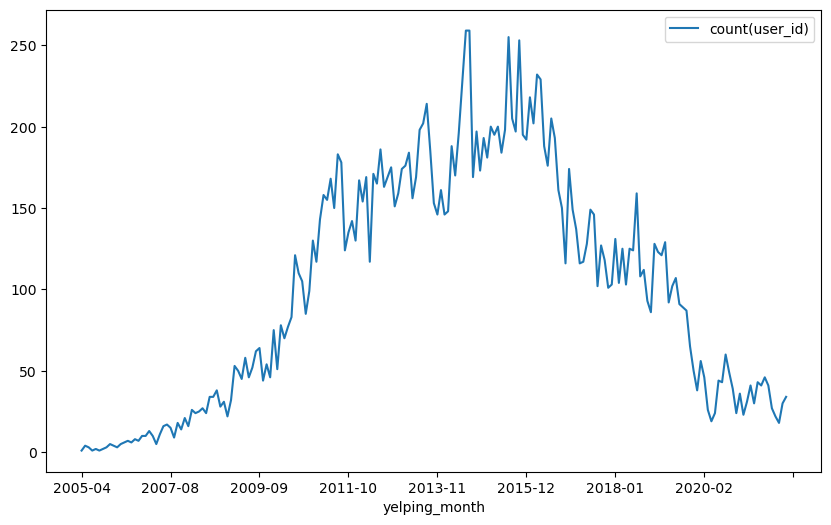

In [122]:
pdf4.plot(kind = 'line', x = 'yelping_month', figsize = (10, 6))